## TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion() 

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../model_dev/COADEL_64_Sampled'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

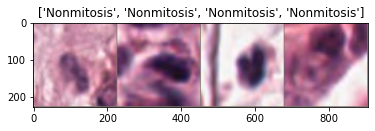

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/jmwolf/anaconda3/envs/wsi_eda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jmwolf/anaconda3/envs/wsi_eda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7395 Acc: 0.6759
val Loss: 0.5373 Acc: 0.7437

Epoch 1/24
----------
train Loss: 0.6140 Acc: 0.7099
val Loss: 0.6201 Acc: 0.7770

Epoch 2/24
----------
train Loss: 0.5871 Acc: 0.7233
val Loss: 0.4987 Acc: 0.7616

Epoch 3/24
----------
train Loss: 0.5608 Acc: 0.7333
val Loss: 0.4792 Acc: 0.8159

Epoch 4/24
----------
train Loss: 0.5459 Acc: 0.7426
val Loss: 0.4301 Acc: 0.8159

Epoch 5/24
----------
train Loss: 0.5350 Acc: 0.7460
val Loss: 0.5260 Acc: 0.8029

Epoch 6/24
----------
train Loss: 0.5161 Acc: 0.7697
val Loss: 0.5642 Acc: 0.7664

Epoch 7/24
----------
train Loss: 0.4672 Acc: 0.7921
val Loss: 0.4150 Acc: 0.8037

Epoch 8/24
----------
train Loss: 0.4468 Acc: 0.7950
val Loss: 0.4095 Acc: 0.8143

Epoch 9/24
----------
train Loss: 0.4430 Acc: 0.7889
val Loss: 0.4008 Acc: 0.8135

Epoch 10/24
----------
train Loss: 0.4462 Acc: 0.7968
val Loss: 0.3979 Acc: 0.8200

Epoch 11/24
----------
train Loss: 0.4501 Acc: 0.7921
val Loss: 0.3982 Acc: 0.8240

Ep

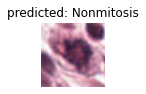

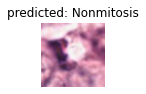

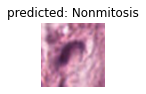

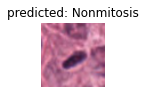

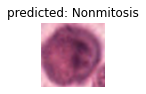

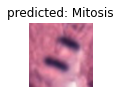

In [14]:
visualize_model(model_ft)

In [29]:
torch.save(model_ft, 'model_rn18.pth')

NameError: name 'model_ft' is not defined

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7036 Acc: 0.6735
val Loss: 0.5725 Acc: 0.7072

Epoch 1/24
----------
train Loss: 0.7122 Acc: 0.6777
val Loss: 0.6294 Acc: 0.6610

Epoch 2/24
----------
train Loss: 0.6944 Acc: 0.6825
val Loss: 0.6199 Acc: 0.7413

Epoch 3/24
----------
train Loss: 0.7102 Acc: 0.6788
val Loss: 0.6259 Acc: 0.6813

Epoch 4/24
----------
train Loss: 0.7358 Acc: 0.6798
val Loss: 0.8242 Acc: 0.7332

Epoch 5/24
----------
train Loss: 0.6781 Acc: 0.6893
val Loss: 0.6017 Acc: 0.6999

Epoch 6/24
----------
train Loss: 0.7141 Acc: 0.6833
val Loss: 1.2330 Acc: 0.4477

Epoch 7/24
----------
train Loss: 0.5884 Acc: 0.7112
val Loss: 0.5324 Acc: 0.7372

Epoch 8/24
----------
train Loss: 0.5732 Acc: 0.7183
val Loss: 0.6057 Acc: 0.6845

Epoch 9/24
----------
train Loss: 0.5628 Acc: 0.7270
val Loss: 0.5197 Acc: 0.7543

Epoch 10/24
----------
train Loss: 0.5655 Acc: 0.7273
val Loss: 0.5222 Acc: 0.7372

Epoch 11/24
----------
train Loss: 0.5671 Acc: 0.7231
val Loss: 0.5215 Acc: 0.7429

Ep

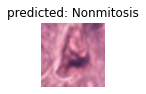

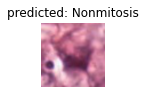

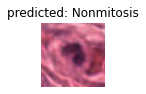

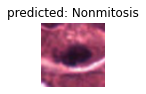

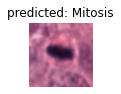

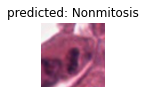

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [4]:
model_rn34= models.resnet34(pretrained=False)

/home/jmwolf/anaconda3/envs/wsi_eda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
num_ftrs = model_rn34.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_rn34.fc = nn.Linear(num_ftrs, 2)

#model_vgg16.classifier[6] = nn.Linear(4096, 2)

model_rn34 = model_rn34.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_rn34.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_rn34 = train_model(model_rn34, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7248 Acc: 0.6656
val Loss: 0.7788 Acc: 0.7194

Epoch 1/24
----------
train Loss: 0.6593 Acc: 0.6830
val Loss: 0.5783 Acc: 0.7599

Epoch 2/24
----------
train Loss: 0.6217 Acc: 0.6933
val Loss: 0.5664 Acc: 0.7388

Epoch 3/24
----------
train Loss: 0.5717 Acc: 0.7215
val Loss: 0.5169 Acc: 0.7705

Epoch 4/24
----------
train Loss: 0.5884 Acc: 0.7173
val Loss: 0.6859 Acc: 0.7397

Epoch 5/24
----------
train Loss: 0.5681 Acc: 0.7299
val Loss: 0.6790 Acc: 0.7437

Epoch 6/24
----------
train Loss: 0.5636 Acc: 0.7352
val Loss: 0.4776 Acc: 0.7705

Epoch 7/24
----------
train Loss: 0.5319 Acc: 0.7441
val Loss: 0.4682 Acc: 0.7778

Epoch 8/24
----------
train Loss: 0.5252 Acc: 0.7518
val Loss: 0.4418 Acc: 0.8021

Epoch 9/24
----------
train Loss: 0.5227 Acc: 0.7507
val Loss: 0.4448 Acc: 0.8021

Epoch 10/24
----------
train Loss: 0.5279 Acc: 0.7460
val Loss: 0.4493 Acc: 0.7997

Epoch 11/24
----------
train Loss: 0.5128 Acc: 0.7552
val Loss: 0.4512 Acc: 0.7916

Ep

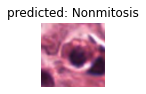

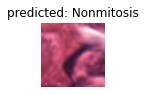

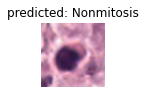

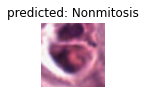

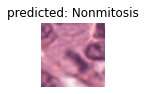

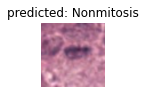

In [18]:
visualize_model(model_rn34)

plt.ioff()
plt.show()

In [28]:
torch.save(model_rn34, 'model_rn34.pth')

In [15]:
model_rn50= models.resnet50(pretrained=False)

In [16]:
num_ftrs = model_rn50.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_rn50.fc = nn.Linear(num_ftrs, 2)

#model_vgg16.classifier[6] = nn.Linear(4096, 2)

model_rn50 = model_rn50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_rn50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_rn50 = train_model(model_rn50, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0425 Acc: 0.6343
val Loss: 1.3188 Acc: 0.7194

Epoch 1/24
----------
train Loss: 0.7564 Acc: 0.6611
val Loss: 0.9251 Acc: 0.7194

Epoch 2/24
----------
train Loss: 0.6806 Acc: 0.6954
val Loss: 0.6032 Acc: 0.6496

Epoch 3/24
----------
train Loss: 0.6680 Acc: 0.6891
val Loss: 1.5479 Acc: 0.7194

Epoch 4/24
----------
train Loss: 0.6607 Acc: 0.6870
val Loss: 1.1370 Acc: 0.7291

Epoch 5/24
----------
train Loss: 0.6385 Acc: 0.6941
val Loss: 1.3764 Acc: 0.7194

Epoch 6/24
----------
train Loss: 0.6470 Acc: 0.6925
val Loss: 0.5266 Acc: 0.7453

Epoch 7/24
----------
train Loss: 0.5504 Acc: 0.7238
val Loss: 0.5005 Acc: 0.7453

Epoch 8/24
----------
train Loss: 0.5500 Acc: 0.7257
val Loss: 0.4952 Acc: 0.7364

Epoch 9/24
----------
train Loss: 0.5444 Acc: 0.7339
val Loss: 0.5337 Acc: 0.7616

Epoch 10/24
----------
train Loss: 0.5431 Acc: 0.7307
val Loss: 0.5078 Acc: 0.7388

Epoch 11/24
----------
train Loss: 0.5437 Acc: 0.7339
val Loss: 0.5874 Acc: 0.7388

Ep

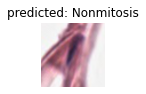

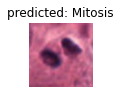

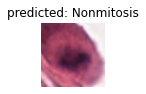

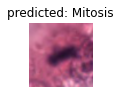

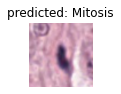

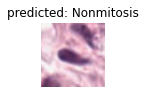

In [19]:
visualize_model(model_rn34)

plt.ioff()
plt.show()

In [27]:
torch.save(model_rn50, 'model_rn50.pth')

In [20]:
from torchvision.models import resnet50, ResNet50_Weights

In [21]:
model_rn50_v2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [22]:
num_ftrs = model_rn50_v2.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_rn50_v2.fc = nn.Linear(num_ftrs, 2)

#model_vgg16.classifier[6] = nn.Linear(4096, 2)

model_rn50_v2 = model_rn50_v2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_rn50_v2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_rn50_v2 = train_model(model_rn50_v2, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5663 Acc: 0.7254
val Loss: 0.4982 Acc: 0.7664

Epoch 1/24
----------
train Loss: 0.5296 Acc: 0.7510
val Loss: 0.4572 Acc: 0.7916

Epoch 2/24
----------
train Loss: 0.5074 Acc: 0.7631
val Loss: 0.4382 Acc: 0.7981

Epoch 3/24
----------
train Loss: 0.4927 Acc: 0.7723
val Loss: 0.4268 Acc: 0.8021

Epoch 4/24
----------
train Loss: 0.4742 Acc: 0.7765
val Loss: 0.4394 Acc: 0.8005

Epoch 5/24
----------
train Loss: 0.4543 Acc: 0.7953
val Loss: 0.4218 Acc: 0.8110

Epoch 6/24
----------
train Loss: 0.4456 Acc: 0.7955
val Loss: 0.4440 Acc: 0.8029

Epoch 7/24
----------
train Loss: 0.4171 Acc: 0.8095
val Loss: 0.4030 Acc: 0.8208

Epoch 8/24
----------
train Loss: 0.4144 Acc: 0.8140
val Loss: 0.3987 Acc: 0.8297

Epoch 9/24
----------
train Loss: 0.4039 Acc: 0.8150
val Loss: 0.4026 Acc: 0.8224

Epoch 10/24
----------
train Loss: 0.3991 Acc: 0.8211
val Loss: 0.4192 Acc: 0.8127

Epoch 11/24
----------
train Loss: 0.4014 Acc: 0.8163
val Loss: 0.3953 Acc: 0.8329

Ep

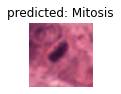

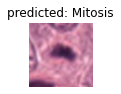

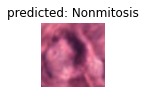

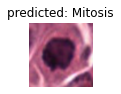

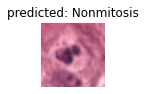

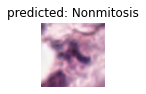

In [24]:
visualize_model(model_rn34)

plt.ioff()
plt.show()

In [25]:
!pwd

/home/jmwolf/repos/XAI_Healthcare/model_dev


In [26]:
torch.save(model_rn50_v2, 'model_rn50_v2.pth')

In [1]:
#test